In [1]:
import sys, os, math, tempfile, datetime, time, copy, re
import numpy as np
import pandas as pd
from allennlp.commands.elmo import ElmoEmbedder
from collections import Counter, defaultdict
from keras.layers import Input, Dense
from keras.models import Model 
from keras.models import model_from_json
from math import log
from pathlib import Path
import pickle
from scipy.stats import percentileofscore
from sklearn.preprocessing import LabelEncoder
import argparse
import torch
import multiprocessing.pool
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from collections import defaultdict  
from sklearn.metrics import accuracy_score, auc, average_precision_score, confusion_matrix, roc_curve, precision_recall_curve, roc_auc_score, recall_score, precision_score

Using TensorFlow backend.


In [3]:
shift, slicesize = 14, 29
path_sequences = "./supporting_file/uniprot_seq.tsv"
df_sequences = pd.read_csv(path_sequences,sep=",")
d_seqs = {}
for index,row in df_sequences.iterrows():
    d_seqs[row["Entry_Isoform"]] = row["Sequence"]

def import_model():
    json_f = open("./models/degron_DL.json", 'r')
    loaded_model_json = json_f.read()
    json_f.close()
    loaded_model = model_from_json(loaded_model_json)
    loaded_model.load_weights('./models/degron_DL.h5')
    return loaded_model

def AA_encoding(seq_extended):
    amino = "ABCDEFGHIJKLMNOPQRSTUVWXYZ-"
    encoder = LabelEncoder()
    encoder.fit(list(amino))
    seq_transformed = np.array(
        list(map(encoder.transform, np.array([list(i.upper()) for i in seq_extended]))))   
    return seq_transformed[0]

In [4]:
class Elmo_embedder():
    def __init__(self, model_dir="./models/uniref50_v2", weights="weights.hdf5",
                 options="options.json", threads=100): 
        if threads == 100:
            torch.set_num_threads(multiprocessing.cpu_count() // 2)
        else:
            torch.set_num_threads(threads)

        self.model_dir = Path(model_dir)
        self.weights = self.model_dir / weights
        self.options = self.model_dir / options
        self.seqvec = ElmoEmbedder(self.options, self.weights, cuda_device=-1)

    def elmo_embedding(self, x, start=None, stop=None):
        assert start is None and stop is None, "deprecated to use start stop, please trim seqs beforehand"

        if type(x[0]) == str:
            x = np.array([list(i.upper()) for i in x])
        embedding = self.seqvec.embed_sentences(x)
        X_parsed = []
        for i in embedding:
            X_parsed.append(i.mean(axis=0))
        return X_parsed
    
elmo_embedder = Elmo_embedder(threads=60)   
loaded_model = import_model() 

Instructions for updating:
If using Keras pass *_constraint arguments to layers.



2024-05-12 23:16:47.309206: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/gridview//pbs/dispatcher/lib:/opt/gridview//pbs/dispatcher/lib::/usr/local/lib64:/usr/local/lib:/usr/local/lib64:/usr/local/lib
2024-05-12 23:16:47.309245: E tensorflow/stream_executor/cuda/cuda_driver.cc:318] failed call to cuInit: UNKNOWN ERROR (303)
2024-05-12 23:16:47.309271: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (node4): /proc/driver/nvidia/version does not exist
2024-05-12 23:16:47.310341: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 AVX512F FMA
2024-05-12 23:16:47.339552: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2400000000 Hz
2024-05-12 

### Predicting E3 ligase targeted degrons using deep learning

In [7]:
test_file = './data/test_properties.tsv'
df_matches = pd.read_csv(test_file, sep="\t")

X_local, all_seq_transformed, all_seq_elmo_embedding = [], [], []
m = 0
for index,row in df_matches.iterrows():
    m = m + 1
    seq_local = d_seqs[row['Entry']]
    seq_len = len(seq_local)
    seq_local = seq_local.upper()
    seq_local_list = np.array(list(seq_local))

    X_embedding = elmo_embedder.elmo_embedding(seq_local_list)
    protein_pad_global = np.zeros((seq_len + (shift * 2), 1024), dtype=np.float32)

    for i in range(0, seq_len, 1):
        protein_pad_global[i + (shift)] = X_embedding[i]

    protein_pad_local = ["-"] * (seq_len + (shift * 2))
    for i in range(0, seq_len, 1):
        protein_pad_local[i + (shift)] = seq_local[i]
    protein_pad_local = "".join(protein_pad_local)

    start_origin = int(row['Start'])-1
    stop_origin = int(row['End'])
    motif = row['DEGRON']
    degron = row['Hit']
    start = start_origin + shift
    stop = stop_origin + shift
    median_pos = (start+stop-1)//2
    slice_start = median_pos - slicesize // 2
    slice_stop = slice_start + slicesize
    query_seq = protein_pad_local[slice_start:slice_stop]
    seq_transformed = AA_encoding([query_seq])
    all_seq_transformed.append(seq_transformed)
    seq_elmo_embedding = protein_pad_global[slice_start:slice_stop]
    all_seq_elmo_embedding.append(seq_elmo_embedding)
    
    print(m)
    
probs_p = loaded_model.predict([all_seq_elmo_embedding, all_seq_transformed]) 
probs_p1 = [float(i) for i in probs_p]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19



In [8]:
simulated = './supporting_file/simulated_degrons.tsv.gz'
df_simulated = pd.read_csv(simulated,sep="\t",compression="gzip")
df_simulated = df_simulated[df_simulated["CONS_SCORE"]>0]
df_simulated=df_simulated.dropna(axis=0)

df_simulated["length"] = df_simulated.apply(lambda x: x["END"] - x["START"], axis=1)
df_simulated = df_simulated.loc[df_simulated['length'].isin([5,6])]  # some_values是可迭代对象
df_simulated = df_simulated.sample(n=5*len(df_matches), replace=True, random_state=2024509)

In [9]:
X_local, all_seq_transformed, all_seq_elmo_embedding = [], [], []
m = 0
for index,row in df_simulated.iterrows():
    m = m + 1
    seq_local = d_seqs[row['Entry']]
    seq_len = len(seq_local)
    seq_local = seq_local.upper()
    seq_local_list = np.array(list(seq_local))

    X_embedding = elmo_embedder.elmo_embedding(seq_local_list)
    protein_pad_global = np.zeros((seq_len + (shift * 2), 1024), dtype=np.float32)

    for i in range(0, seq_len, 1):
        protein_pad_global[i + (shift)] = X_embedding[i]

    protein_pad_local = ["-"] * (seq_len + (shift * 2))
    for i in range(0, seq_len, 1):
        protein_pad_local[i + (shift)] = seq_local[i]
    protein_pad_local = "".join(protein_pad_local)

    start_origin = int(row['START'])-1
    stop_origin = int(row['END'])
    motif = row['DEGRON']
    start = start_origin + shift
    stop = stop_origin + shift
    median_pos = (start+stop-1)//2
    slice_start = median_pos - slicesize // 2
    slice_stop = slice_start + slicesize
    query_seq = protein_pad_local[slice_start:slice_stop]
    seq_transformed = AA_encoding([query_seq])
    all_seq_transformed.append(seq_transformed)
    seq_elmo_embedding = protein_pad_global[slice_start:slice_stop]
    all_seq_elmo_embedding.append(seq_elmo_embedding)
    
    print(m)
    
probs_n = loaded_model.predict([all_seq_elmo_embedding, all_seq_transformed]) 
probs_n1 = [float(i) for i in probs_n]

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100


In [10]:
MetaDegron_D_predicted_probs = np.concatenate((probs_p,probs_n)) 
MetaDegron_D_true_labels = np.concatenate((np.ones((len(probs_p),), dtype=np.int),np.zeros((len(probs_n),), dtype=np.int)), axis=0)
MetaDegron_D_fpr, MetaDegron_D_tpr, _ = roc_curve(MetaDegron_D_true_labels, MetaDegron_D_predicted_probs)
MetaDegron_D_auc_value = auc(MetaDegron_D_fpr, MetaDegron_D_tpr)

/public/home/hxu6/anaconda3/envs/tens37/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


0.9574999999999999

### Predicting E3 ligase targeted degrons using XGBoost model trained on multimodal feature 

In [20]:
classifier_XGBoost  = "./models/classifier_XGBoost.pickle"

out_file = './prediction'
test_data = './data/test_properties.tsv'
df_properties = pd.read_csv(test_data, sep="\t")

covariates = ['solvent_accessibility', 'disorder', 'conservative_score', 'coiled_coil',
              'anchoring_score', 'flanking_ptms', 'flanking_ub_lysine', 
              'a_helix', 'flexibility',  'structured_domain',  ]

pred =["ASA_SCORE","DSS_SCORE","FCONS_SCORE","COIL",
       "ANCHOR_SCORE","nflanking_ptms","nflanking_ub_lysines",
       "HELIX","RIG_SCORE","Domain_pfam"]

clf = pickle.load(open(classifier_XGBoost, "rb"))
p_probs = clf.predict_proba(df_properties[covariates])
p_probs = [l[1] for l in p_probs]

In [21]:
simulated = './supporting_file/simulated_degrons.tsv.gz'
df_simulated = pd.read_csv(simulated,sep="\t",compression="gzip")
df_simulated = df_simulated[df_simulated["CONS_SCORE"]>0]
df_simulated=df_simulated.dropna(axis=0)

df_simulated["length"] = df_simulated.apply(lambda x: x["END"] - x["START"], axis=1)
df_simulated = df_simulated.loc[df_simulated['length'].isin([5,6])]  # some_values是可迭代对象
df_simulated = df_simulated.sample(n=5*len(df_matches), replace=True, random_state=2024509)

In [22]:
n_probs = clf.predict_proba(df_simulated[pred])
n_probs = [l[1] for l in n_probs]

In [25]:
MetaDegron_X_predicted_probs = np.concatenate((p_probs,n_probs)) 
MetaDegron_X_true_labels = np.concatenate((np.ones((len(p_probs),), dtype=np.int),np.zeros((len(n_probs),), dtype=np.int)), axis=0)
MetaDegron_X_fpr, MetaDegron_X_tpr, _ = roc_curve(MetaDegron_X_true_labels, MetaDegron_X_predicted_probs)
MetaDegron_X_auc_value = auc(MetaDegron_X_fpr, MetaDegron_X_tpr)

/public/home/hxu6/anaconda3/envs/tens37/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


0.9475

In [28]:
Degpred_file = './supporting_file/Degpred_probas.txt'
Degpred_RES = pd.read_csv(Degpred_file, sep='\t')
data = np.array(Degpred_RES)
all_lable = data[:,0].astype(np.float)
all_score = data[:,1].astype(np.float)
Degpred_fpr, Degpred_tpr, _ = roc_curve(all_lable, all_score)
Degpred_auc_value = auc(Degpred_fpr, Degpred_tpr)


FileNotFoundError: [Errno 2] No such file or directory: './Degpred_probas.txt'

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


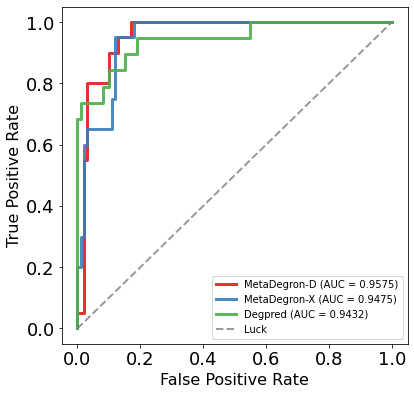

In [27]:
font1 = {'family' : 'Times New Roman',
        'weight' : 'normal',
        'size'   : 16}
figsize=6.2, 6.2

figure1, ax1 = plt.subplots(figsize=figsize)
ax1.tick_params(labelsize=18)
labels = ax1.get_xticklabels() + ax1.get_yticklabels()
[label.set_fontname('Times New Roman') for label in labels]   

colorlist=plt.get_cmap('Set1')([0,1,2])

ax1.plot(MetaDegron_D_fpr, MetaDegron_D_tpr, lw=3, alpha=0.9, color = colorlist[0],
        label='%s (AUC = %0.4f)' % ('MetaDegron-D', MetaDegron_D_auc_value))

ax1.plot(MetaDegron_X_fpr, MetaDegron_X_tpr, lw=3, alpha=0.9, color = colorlist[1],
        label='%s (AUC = %0.4f)' % ('MetaDegron-X', MetaDegron_X_auc_value))

ax1.plot(Degpred_fpr, Degpred_tpr, lw=3, alpha=0.9, color = colorlist[2],
        label='%s (AUC = %0.4f)' % ('Degpred', Degpred_auc_value))

ax1.plot([0, 1], [0, 1], linestyle='--', lw=2, color='grey',
        label='Luck', alpha=.8)

ax1.set_xlim([-0.05, 1.05])
ax1.set_ylim([-0.05, 1.05])
ax1.set_xlabel('False Positive Rate', font1)
ax1.set_ylabel('True Positive Rate', font1)

ax1.legend(loc="lower right")